In [1]:
import pandas as pd
import cupy as cp
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import pylab
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, FixedLocator
from matplotlib.widgets import Cursor
import seaborn as sns
from scipy.stats import skew as skew

from numba import jit, cuda, njit, prange
from timeit import default_timer as timer
import time


In [2]:
dt = .001
tau = .1
noise_tau = .002
w11, w22 = 1, 1
w21, w12 = 1, 1
dur = 5
bifurcate_time = 0
threshold = 70
S = 576
R_initial = 42
sgm = 10
eta = S*0

In [3]:
#@njit(parallel=True, fastmath=True)
@njit
def ave_choice(coh, a, b):
    tauR, tauG, tauD = .185325, .224459, .323132
    nan_num = 0
    alpha = a
    beta = 0

    S = (w11+w12) * R_initial**2 + (1-alpha) * R_initial

    reaction_time = np.zeros(10240)
    choice = np.zeros(10240)

    for i in prange(10240):

        beta = 0
        V1, V2 = S, S

        R1_arr = np.zeros(int(dur/dt))
        R2_arr = np.zeros(int(dur/dt))
        R1_arr[0], R2_arr[0] = R_initial, R_initial
        # R1_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w11+w12-beta))) / (2*(w11+w12-beta))
        # R2_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w22+w21-beta))) / (2*(w22+w21-beta))

        G1_arr = np.zeros(int(dur/dt))
        G2_arr = np.zeros(int(dur/dt))
        G1_arr[0], G2_arr[0] = (w11+w12)*R1_arr[0], (w22+w21)*R2_arr[0]

        D1_arr = np.zeros(int(dur/dt))
        D2_arr = np.zeros(int(dur/dt))
        D1_arr[0], D2_arr[0] = 0*R1_arr[0], 0*R2_arr[0]

        noise_R1 = np.zeros(int(dur/dt))
        noise_R2 = np.zeros(int(dur/dt))
        noise_G1 = np.zeros(int(dur/dt))
        noise_G2 = np.zeros(int(dur/dt))
        noise_D1 = np.zeros(int(dur/dt))
        noise_D2 = np.zeros(int(dur/dt))

        for ti in range(1, int(dur/dt)):

            if ti >= bifurcate_time/dt:
                beta = b
                V1 = S*(1+coh)
                V2 = S*(1-coh)

            if ti >= bifurcate_time/dt and ti % 5 == 0:
                V1 = S*(1+coh) + np.random.randn() * eta
                V2 = S*(1-coh) + np.random.randn() * eta

            d_noiseR1 = (-noise_R1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseR2 = (-noise_R2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG1 = (-noise_G1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG2 = (-noise_G2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD1 = (-noise_D1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD2 = (-noise_D2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt

            d_R1 = (-R1_arr[ti-1] + (alpha * R1_arr[ti-1] + V1) / (1 + G1_arr[ti-1])) * dt/tauR
            d_R2 = (-R2_arr[ti-1] + (alpha * R2_arr[ti-1] + V2) / (1 + G2_arr[ti-1])) * dt/tauR
            d_G1 = (-G1_arr[ti-1] + w11*R1_arr[ti-1] + w12*R2_arr[ti-1] - D1_arr[ti-1]) * dt/tauG
            d_G2 = (-G2_arr[ti-1] + w21*R1_arr[ti-1] + w22*R2_arr[ti-1] - D2_arr[ti-1]) * dt/tauG
            d_D1 = (-D1_arr[ti-1] + beta*R1_arr[ti-1]) *dt/tauD
            d_D2 = (-D2_arr[ti-1] + beta*R2_arr[ti-1]) *dt/tauD

            noise_R1[ti] = noise_R1[ti-1] + d_noiseR1
            noise_R2[ti] = noise_R2[ti-1] + d_noiseR2
            noise_G1[ti] = noise_G1[ti-1] + d_noiseG1
            noise_G2[ti] = noise_G2[ti-1] + d_noiseG2
            noise_D1[ti] = noise_D1[ti-1] + d_noiseD1
            noise_D2[ti] = noise_D2[ti-1] + d_noiseD2

            R1_arr[ti] = max(R1_arr[ti-1] + d_R1 + noise_R1[ti], 0)
            R2_arr[ti] = max(R2_arr[ti-1] + d_R2 + noise_R2[ti], 0)
            G1_arr[ti] = max(G1_arr[ti-1] + d_G1 + noise_G1[ti], 0)
            G2_arr[ti] = max(G2_arr[ti-1] + d_G2 + noise_G2[ti], 0)
            D1_arr[ti] = max(D1_arr[ti-1] + d_D1 + noise_D1[ti], 0)
            D2_arr[ti] = max(D2_arr[ti-1] + d_D2 + noise_D2[ti], 0)

            if R1_arr[ti] > threshold and ti >= bifurcate_time/dt:
                choice[i] = 1
                reaction_time[i] = int(ti - bifurcate_time/dt)
                break
            elif R2_arr[ti] > threshold and ti >= bifurcate_time/dt:
                reaction_time[i] = int(ti - bifurcate_time/dt)
                break
            elif ti == int(dur/dt-1):
                reaction_time[i] = np.NAN
                choice[i] = np.NAN
                nan_num += 1

    return reaction_time, choice

In [4]:
def clean_bg(axes):
    for ax_row in axes:
        for ax in ax_row:
            ax.tick_params(axis='x', direction="in")
            ax.tick_params(axis="y", direction="in")
            ax.tick_params(bottom=True, left=True)
            ax.spines['bottom'].set_color('0')
            ax.spines['left'].set_color('0')
            ax.patch.set_facecolor('white')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            font_size = 20
            params = {'figure.figsize': (7, 6),
                     'legend.fontsize': font_size,
                     'axes.labelsize': font_size,
                     'axes.titlesize': font_size,
                     'xtick.labelsize': font_size,
                     'ytick.labelsize': font_size}
            pylab.rcParams.update(params)
            plt.grid(False)

In [5]:
alpha_array = np.linspace(10, 80, 5)
beta_array = np.linspace(1, 2., 5)

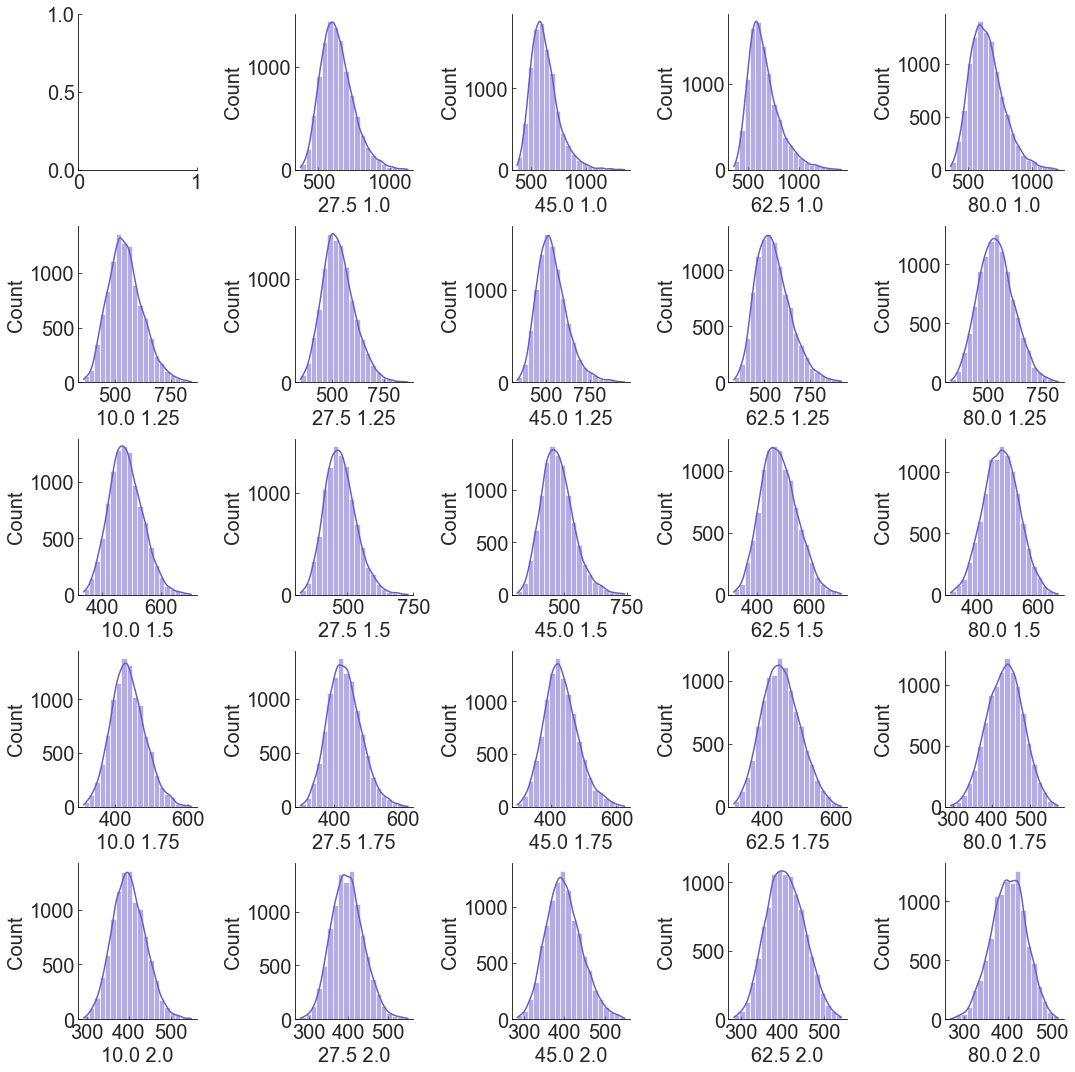

In [18]:
fig, ax = plt.subplots(5,5, figsize=(15, 15))
clean_bg(ax)
for col in range(5):
    for row in range(5):
        if row == col == 0:
            continue
        cur_RT, _ = ave_choice(.256, alpha_array[col], beta_array[row])
        title = str(alpha_array[col])+" "+str(beta_array[row])
        df = pd.DataFrame(cur_RT, columns=[title])
        df = df[(df[title].quantile(.001) < df[title]) & (df[title] < df[title].quantile(.999))]
        sns.histplot(data=df, x=title, bins=20, color='#6d5acf', kde=True, ax=ax[row][col])

        # bins = np.arange(min(cur_RT), max(cur_RT), 25)
        # ax[row][col].hist(cur_RT, bins=bins)


plt.tight_layout()
plt.savefig("t")

In [62]:
#@njit(parallel=True, fastmath=True)
@njit
def skew_dynamic(coh, a, b):

    nan_num = 0
    alpha = a
    beta = 0

    R1_arr = np.zeros(int(dur/dt))
    R2_arr = np.zeros(int(dur/dt))
    R1_arr[0], R2_arr[0] = R_initial, R_initial
    S = (w11+w12) * R_initial**2 + (1-alpha) * R_initial
    # R1_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w11+w12-beta))) / (2*(w11+w12-beta))
    # R2_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w22+w21-beta))) / (2*(w22+w21-beta))

    G1_arr = np.zeros(int(dur/dt))
    G2_arr = np.zeros(int(dur/dt))
    G1_arr[0], G2_arr[0] = (w11+w12)*R1_arr[0], (w22+w21)*R2_arr[0]

    D1_arr = np.zeros(int(dur/dt))
    D2_arr = np.zeros(int(dur/dt))
    D1_arr[0], D2_arr[0] = 0*R1_arr[0], 0*R2_arr[0]

    noise_R1 = np.zeros(int(dur/dt))
    noise_R2 = np.zeros(int(dur/dt))
    noise_G1 = np.zeros(int(dur/dt))
    noise_G2 = np.zeros(int(dur/dt))
    noise_D1 = np.zeros(int(dur/dt))
    noise_D2 = np.zeros(int(dur/dt))

    reaction_time = np.zeros(10240)
    choice = np.zeros(10240)
    end_time = dur/dt

    for i in prange(10240):

        beta = 0
        V1, V2 = S, S

        for ti in range(1, int(dur/dt)):

            if ti >= bifurcate_time/dt:
                beta = b
                V1 = S*(1+coh)
                V2 = S*(1-coh)

            if ti >= bifurcate_time/dt and ti % 5 == 0:
                V1 = S*(1+coh) + np.random.randn() * eta
                V2 = S*(1-coh) + np.random.randn() * eta

            d_noiseR1 = (-noise_R1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseR2 = (-noise_R2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG1 = (-noise_G1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG2 = (-noise_G2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD1 = (-noise_D1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD2 = (-noise_D2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt

            d_R1 = (-R1_arr[ti-1] + (alpha * R1_arr[ti-1] + V1) / (1 + G1_arr[ti-1])) * dt/tau
            d_R2 = (-R2_arr[ti-1] + (alpha * R2_arr[ti-1] + V2) / (1 + G2_arr[ti-1])) * dt/tau
            d_G1 = (-G1_arr[ti-1] + w11*R1_arr[ti-1] + w12*R2_arr[ti-1] - D1_arr[ti-1]) * dt/tau
            d_G2 = (-G2_arr[ti-1] + w21*R1_arr[ti-1] + w22*R2_arr[ti-1] - D2_arr[ti-1]) * dt/tau
            d_D1 = (-D1_arr[ti-1] + beta*R1_arr[ti-1]) *dt/tau
            d_D2 = (-D2_arr[ti-1] + beta*R2_arr[ti-1]) *dt/tau

            noise_R1[ti] = noise_R1[ti-1] + d_noiseR1
            noise_R2[ti] = noise_R2[ti-1] + d_noiseR2
            noise_G1[ti] = noise_G1[ti-1] + d_noiseG1
            noise_G2[ti] = noise_G2[ti-1] + d_noiseG2
            noise_D1[ti] = noise_D1[ti-1] + d_noiseD1
            noise_D2[ti] = noise_D2[ti-1] + d_noiseD2

            R1_arr[ti] = max(R1_arr[ti-1] + d_R1 + noise_R1[ti], 0)
            R2_arr[ti] = max(R2_arr[ti-1] + d_R2 + noise_R2[ti], 0)
            G1_arr[ti] = max(G1_arr[ti-1] + d_G1 + noise_G1[ti], 0)
            G2_arr[ti] = max(G2_arr[ti-1] + d_G2 + noise_G2[ti], 0)
            D1_arr[ti] = max(D1_arr[ti-1] + d_D1 + noise_D1[ti], 0)
            D2_arr[ti] = max(D2_arr[ti-1] + d_D2 + noise_D2[ti], 0)

            if R1_arr[ti] > threshold and ti >= bifurcate_time/dt:
                choice[i] = 1
                reaction_time[i] = int(ti - bifurcate_time/dt)
                end_time = ti
                break
            elif R2_arr[ti] > threshold and ti >= bifurcate_time/dt:
                reaction_time[i] = int(ti - bifurcate_time/dt)
                end_time = ti
                break
            elif ti == int(dur/dt-1):
                reaction_time[i] = np.NAN
                choice[i] = np.NAN
                nan_num += 1

    return R1_arr, R2_arr, end_time

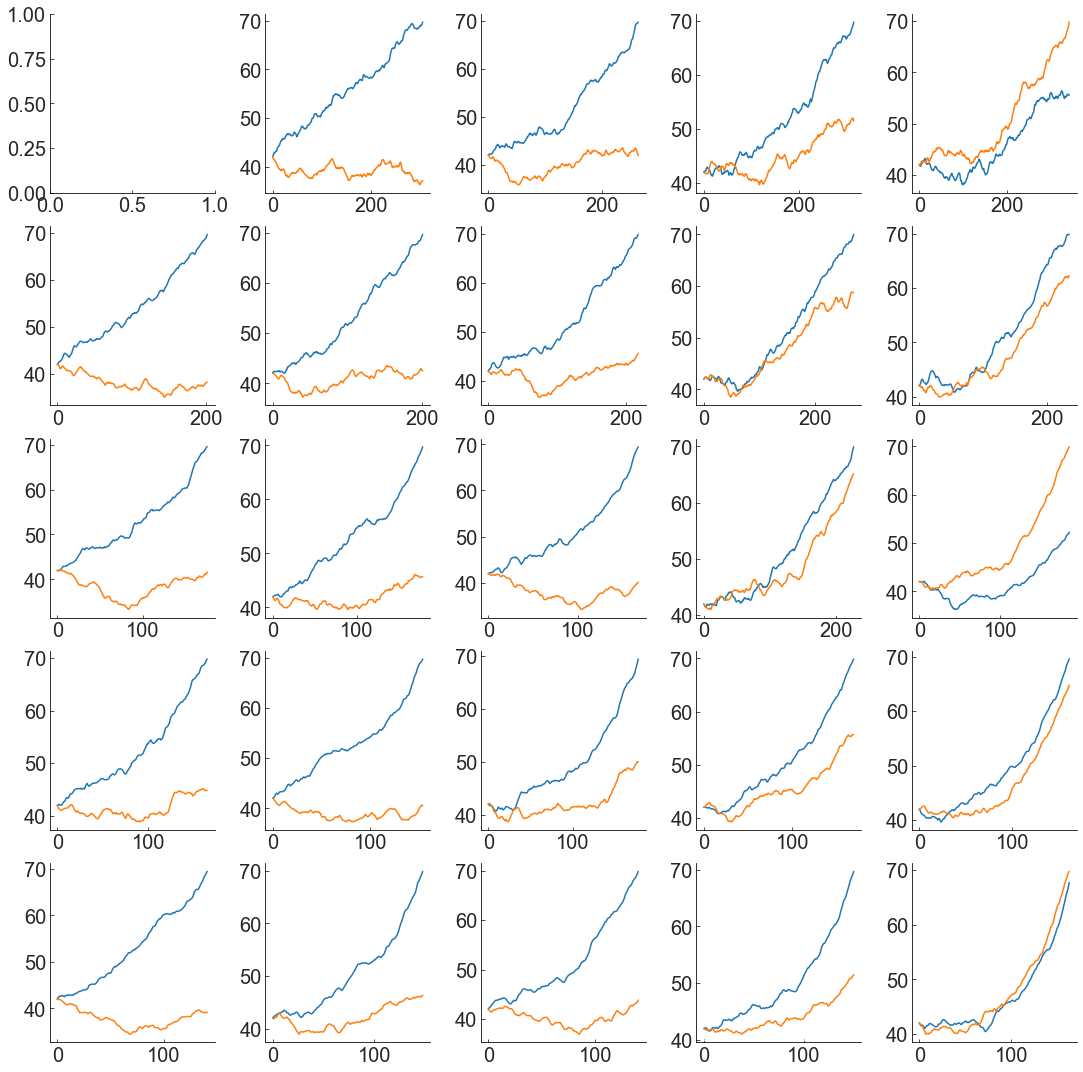

In [68]:
fig, ax = plt.subplots(5,5, figsize=(15, 15))
clean_bg(ax)
for col in range(5):
    for row in range(5):
        if row == col == 0:
            continue
        R1, R2, end = skew_dynamic(.256, alpha_array[col], beta_array[row])
        ax[row][col].plot(np.arange(0, end), R1[:int(end)])
        ax[row][col].plot(np.arange(0, end), R2[:int(end)])


plt.tight_layout()
